# Finding a Location for New Food Store in Toronto, CA

# Introduction
Goyo's of the World is a food store consortium that operates in Toronto, Canada. They have a flag ship grocery store and a variety of smaller stores such as bakerys and small convienance stores. They are looking to open a new store, and want to find the best neighborhood to do so in.  Greg's is flexible in the size of the new store, it could be large or small depending on the area they choose. They would like to analyze the existing make up of food stores in the neighborhoods of Toronto. The new location team will use this data to further investigate what type of store to open.  

# Data
Postal codes and neighborhood names from Wikipedia will be used, along with geospatial coordinates showing neighborhood centers. Data from Foursquare will be used to find appropriate venues within the city of Toronto, using a radius of 1,000 meters from each neighborhood center. Venues will be filtered to only include food stores, not restaurants or cafes.  The top three category types by number of venues will be normalized for clustering purposes. 


In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium==0.5
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 79 kB 1.6 MB/s eta 0:00:011
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=02eb738d59f53f8fb3d521369bf67ee1b9357eed08dad6deed0419b2f5cfe1d5
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Libraries imported.


### Get postal codes and neighborhood information:

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df=pd.read_html(url, header=0)[0]

df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Remove places with unassigned boroughs:

In [3]:
indexNames = df[df['Borough'] == 'Not assigned'].index
indexNames

Int64Index([  0,   1,   7,  10,  15,  16,  19,  24,  25,  28,  29,  33,  34,
             35,  37,  38,  42,  43,  44,  51,  52,  53,  60,  61,  62,  69,
             70,  71,  78,  79,  87,  88,  96,  97, 101, 105, 106, 110, 115,
            118, 119, 123, 124, 125, 127, 128, 131, 132, 133, 134, 136, 137,
            140, 141, 145, 146, 149, 150, 154, 155, 158, 159, 161, 162, 163,
            164, 166, 167, 170, 171, 172, 173, 174, 175, 176, 177, 179],
           dtype='int64')

In [4]:
df.drop(indexNames , inplace=True)

df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
print ('the data frame has shape: ')
df.shape

the data frame has shape: 


(103, 3)

### Retrieve geospatial coordinates of Postal codes for mapping and merge with Neighbourhood names:

In [6]:
url_lat = 'http://cocl.us/Geospatial_data'
df_lat=pd.read_csv(url_lat)
df_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
#merge data using postal codes
df2 = df.merge(df_lat)
df2

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df2['Borough'].unique()),
        df2.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### Let's visualize the initial geodata with a map:

In [9]:
#find lacation of Toronto, Canada
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


In [10]:
#map with neighbourhood central markers

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Borough'], df2['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Use Neighbourhood location data for venue infromation from Foursquare

In [11]:
CLIENT_ID = 'APIPHRU314KKS5GQTKE33USBVQUXQKQT35LRUYCHGDKNK3VA' # Foursquare ID
CLIENT_SECRET = '31AFELDLWCOFQ4ZXHCXLLFP34QRS3WX3FIZ1JBHNKNNYJUDZ' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ', CLIENT_ID)
print('CLIENT_SECRET: ', CLIENT_SECRET)


Your credentails:
CLIENT_ID:  APIPHRU314KKS5GQTKE33USBVQUXQKQT35LRUYCHGDKNK3VA
CLIENT_SECRET:  31AFELDLWCOFQ4ZXHCXLLFP34QRS3WX3FIZ1JBHNKNNYJUDZ


In [12]:
#Explore nieghbourhoods
df2.loc[0,'Neighbourhood']


'Parkwoods'

In [13]:
#Check Longitude and Latitude
neighborhood_latitude = df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df2.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [14]:
#Assume a walking radius of 1000 meters from center of neighbourhhod
#Use radius to assign venues to each neighbourhood
radius = 1000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL



'https://api.foursquare.com/v2/venues/explore?&client_id=APIPHRU314KKS5GQTKE33USBVQUXQKQT35LRUYCHGDKNK3VA&client_secret=31AFELDLWCOFQ4ZXHCXLLFP34QRS3WX3FIZ1JBHNKNNYJUDZ&v=20180605&ll=43.7532586,-79.3296565&radius=1000&limit=100'

In [15]:
results = requests.get(url).json()

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Allwyn's Bakery,Caribbean Restaurant,43.759840,-79.324719
1,Tim Hortons,Café,43.760668,-79.326368
2,Brookbanks Park,Park,43.751976,-79.332140
3,Bruno's valu-mart,Grocery Store,43.746143,-79.324630
4,High Street Fish & Chips,Fish & Chips Shop,43.745260,-79.324949


In [18]:
#see categories of venues
nearby_venues['categories'].unique()

array(['Caribbean Restaurant', 'Café', 'Park', 'Grocery Store',
       'Fish & Chips Shop', 'Fast Food Restaurant', 'Pharmacy',
       'Supermarket', 'Pizza Place', 'Food & Drink Shop', 'Intersection',
       'Bus Stop', 'Train Station', 'Discount Store', 'Laundry Service',
       'ATM', 'Chinese Restaurant', 'Coffee Shop', 'Convenience Store',
       'Shopping Mall', 'Skating Rink', 'Tennis Court', 'Cosmetics Shop',
       'Shop & Service'], dtype=object)

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
#run nearby venues for each neighborhood
toronto_venues = getNearbyVenues(names=df2['Neighbourhood'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [21]:
#Review Categories to extract venues that offer premade food, like Goyo's
toronto_venues['Venue Category'].unique()

array(['Caribbean Restaurant', 'Café', 'Park', 'Grocery Store',
       'Fish & Chips Shop', 'Fast Food Restaurant', 'Pharmacy',
       'Supermarket', 'Pizza Place', 'Food & Drink Shop', 'Intersection',
       'Bus Stop', 'Train Station', 'Discount Store', 'Laundry Service',
       'ATM', 'Chinese Restaurant', 'Coffee Shop', 'Convenience Store',
       'Shopping Mall', 'Skating Rink', 'Tennis Court', 'Cosmetics Shop',
       'Shop & Service', 'Hockey Arena', 'Portuguese Restaurant',
       'Golf Course', 'Sporting Goods Shop', "Men's Store", 'Lounge',
       'Gym / Fitness Center', 'Bakery', 'Restaurant', 'Historic Site',
       'Distribution Center', 'Farmers Market', 'Chocolate Shop',
       'Mediterranean Restaurant', 'Dessert Shop', 'Spa',
       'Performing Arts Venue', 'Liquor Store', 'French Restaurant',
       'Tech Startup', 'Breakfast Spot', 'Italian Restaurant', 'Pub',
       'Thai Restaurant', 'Yoga Studio', 'Animal Shelter', 'Shoe Store',
       'Pool', 'Theater', 'Event Sp

In [22]:
print(toronto_venues.shape)

(4874, 7)


In [23]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,47,47,47,47,47,47
"Alderwood, Long Branch",24,24,24,24,24,24
"Bathurst Manor, Wilson Heights, Downsview North",31,31,31,31,31,31
Bayview Village,15,15,15,15,15,15
"Bedford Park, Lawrence Manor East",41,41,41,41,41,41
...,...,...,...,...,...,...
"Willowdale, Willowdale West",12,12,12,12,12,12
Woburn,8,8,8,8,8,8
Woodbine Heights,26,26,26,26,26,26


In [24]:
print('There are {} unique categories. '.format(len(toronto_venues['Venue Category'].unique())))

There are 335 unique categories. 


In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 


In [26]:
# move neighborhood column to the first column
col_name="Neighborhood"
first_col = toronto_onehot.pop(col_name)
toronto_onehot.head()
toronto_onehot.insert(0, col_name, first_col)
toronto_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
toronto_onehot.shape

(4874, 335)

In [28]:
#keep only venues of interest, as listed below
cols =['Neighborhood', 'Grocery Store', 'Supermarket', 'Food & Drink Shop', 'Convenience Store', 'Bakery', 'Farmers Market', 'Liquor Store', 'Deli / Bodega', 'Pastry Shop', 'Fish Market', 'Bagel Shop', 'Shopping Plaza', 'Smoothie Shop', 'Cheese Shop', 'Candy Store', 'Donut Shop', 'Butcher', 'Fruit & Vegetable Store', 'Food', 'Wine Shop', 'Organic Grocery', 'Pie Shop']
toronto_onehot2 = toronto_onehot[cols]

In [29]:
toronto_test_count = toronto_onehot2.groupby('Neighborhood')


In [30]:
toronto_test_count.head()

,Neighborhood,Grocery Store,Supermarket,Food & Drink Shop,Convenience Store,Bakery,Farmers Market,Liquor Store,Deli / Bodega,Pastry Shop,...,Smoothie Shop,Cheese Shop,Candy Store,Donut Shop,Butcher,Fruit & Vegetable Store,Food,Wine Shop,Organic Grocery,Pie Shop
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4814,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4815,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4816,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4817,"Mimico NW, The Queensway West, South of Bloor,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
toronto_onehot2.groupby('Neighborhood').sum()

,Grocery Store,Supermarket,Food & Drink Shop,Convenience Store,Bakery,Farmers Market,Liquor Store,Deli / Bodega,Pastry Shop,Fish Market,...,Smoothie Shop,Cheese Shop,Candy Store,Donut Shop,Butcher,Fruit & Vegetable Store,Food,Wine Shop,Organic Grocery,Pie Shop
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Alderwood, Long Branch",1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
"Bathurst Manor, Wilson Heights, Downsview North",0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Bedford Park, Lawrence Manor East",1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale West",1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Woburn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Woodbine Heights,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Data Exploration

In [32]:
#visualize number of venues by frequency
torontoTEST = toronto_onehot2.groupby('Neighborhood').sum()

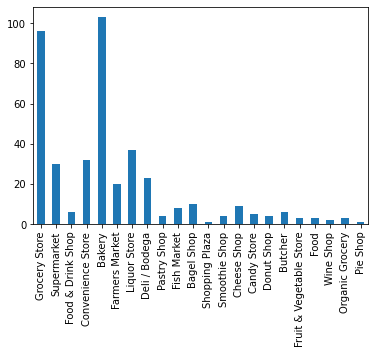

In [33]:
torontoTEST.sum(axis=0).plot(kind='bar')

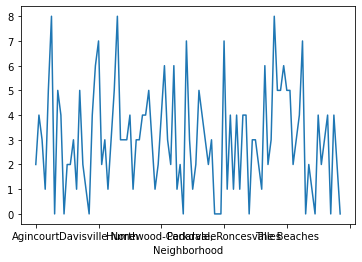

In [34]:
#visualize number of venues per neighborhood
toronto_condense_test = toronto_onehot2.groupby('Neighborhood').sum()
toronto_condense_test.astype(bool).sum(axis=1).plot()

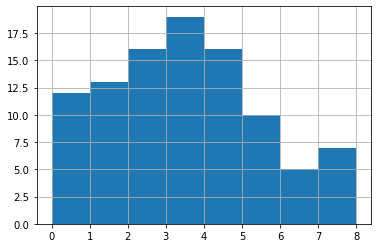

In [35]:
toronto_condense_test.astype(bool).sum(axis=1).hist(bins = 8)

In [36]:
#We will be looking at the top three venue types per neiborhood. There are neighborhoods with less that three venue types. We will add columns for these before normalization

toronto_condense_test['Less Than 3'] = np.where(toronto_condense_test.astype(bool).sum(axis=1) < 3, 1, 0)

In [37]:
toronto_condense_test['Less Than 2'] = np.where(toronto_condense_test.astype(bool).sum(axis=1) < 3, 2, 0)

In [38]:
toronto_condense_test['No Relevant Venues'] = np.where(toronto_condense_test.astype(bool).sum(axis=1) < 3, 3, 0)

In [40]:
#Check that each neighborhood has at least 3 venue types
sum(toronto_condense_test.astype(bool).sum(axis=1) < 3)

0

In [41]:
#number of venue types per neighborhood
toronto_condense_test.astype(bool).sum(axis=1)

Neighborhood
Agincourt                                          3
Alderwood, Long Branch                             4
Bathurst Manor, Wilson Heights, Downsview North    3
Bayview Village                                    3
Bedford Park, Lawrence Manor East                  5
                                                  ..
Willowdale, Willowdale West                        4
Woburn                                             3
Woodbine Heights                                   4
York Mills West                                    3
York Mills, Silver Hills                           3
Length: 98, dtype: int64

In [42]:
toronto_condense_test.tail()

,Grocery Store,Supermarket,Food & Drink Shop,Convenience Store,Bakery,Farmers Market,Liquor Store,Deli / Bodega,Pastry Shop,Fish Market,...,Donut Shop,Butcher,Fruit & Vegetable Store,Food,Wine Shop,Organic Grocery,Pie Shop,Less Than 3,Less Than 2,No Relevant Venues
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Willowdale, Willowdale West",1,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Woburn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,3
Woodbine Heights,0,0,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
York Mills West,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
"York Mills, Silver Hills",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,3


In [43]:
toronto_condense_test.sum(axis = 0)

Grocery Store               96
Supermarket                 30
Food & Drink Shop            6
Convenience Store           32
Bakery                     103
Farmers Market              20
Liquor Store                37
Deli / Bodega               23
Pastry Shop                  4
Fish Market                  8
Bagel Shop                  10
Shopping Plaza               1
Smoothie Shop                4
Cheese Shop                  9
Candy Store                  5
Donut Shop                   4
Butcher                      6
Fruit & Vegetable Store      3
Food                         3
Wine Shop                    2
Organic Grocery              3
Pie Shop                     1
Less Than 3                 41
Less Than 2                 50
No Relevant Venues          36
dtype: int64

In [71]:
#df.div(df.sum(axis=1), axis=0)

In [48]:
#Normalize by row

#toronto_grouped = toronto_condense_test.groupby('Neighborhood').mean().reset_index()
#toronto_grouped.head()

toronto_condense_test = toronto_condense_test.div(toronto_condense_test.sum(axis=1), axis=0)


In [49]:
toronto_grouped = toronto_condense_test.reset_index()

In [50]:
num_top_venues = 3

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
         venue  freq
0       Bakery  0.50
1  Less Than 3  0.25
2  Supermarket  0.25


----Alderwood, Long Branch----
               venue  freq
0      Grocery Store  0.25
1  Convenience Store  0.25
2       Liquor Store  0.25


----Bathurst Manor, Wilson Heights, Downsview North----
               venue  freq
0  Convenience Store  0.33
1      Deli / Bodega  0.33
2        Supermarket  0.33


----Bayview Village----
           venue  freq
0    Less Than 2  0.50
1  Grocery Store  0.25
2    Less Than 3  0.25


----Bedford Park, Lawrence Manor East----
           venue  freq
0  Grocery Store   0.2
1         Bakery   0.2
2   Liquor Store   0.2


----Berczy Park----
            venue  freq
0   Grocery Store  0.17
1          Bakery  0.17
2  Farmers Market  0.17


----Birch Cliff, Cliffside West----
                venue  freq
0  No Relevant Venues  0.50
1         Less Than 2  0.33
2         Less Than 3  0.17


----Brockton, Parkdale Village, Exhibition Place----
          venu

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Bakery,Less Than 3,Supermarket
1,"Alderwood, Long Branch",Grocery Store,Convenience Store,Liquor Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Supermarket,Convenience Store,Deli / Bodega
3,Bayview Village,Less Than 2,Grocery Store,Less Than 3
4,"Bedford Park, Lawrence Manor East",Grocery Store,Bakery,Liquor Store


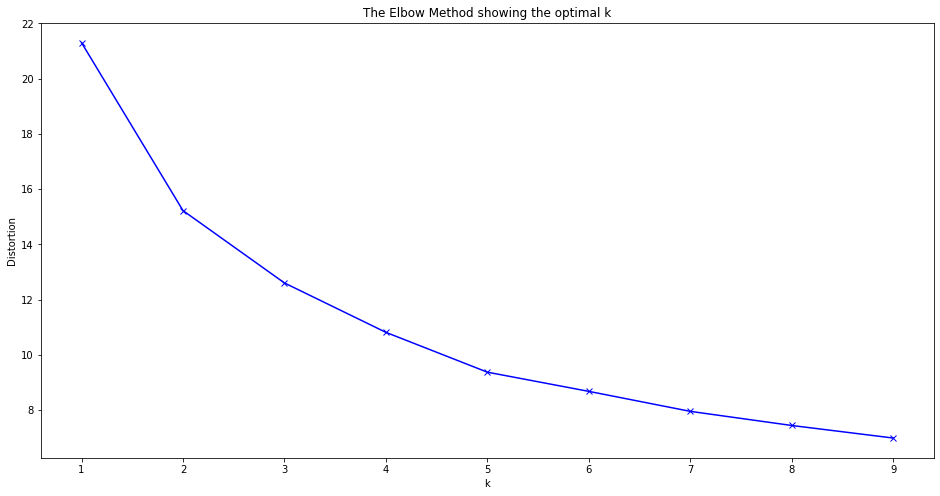

In [53]:
# Create a new dataframe and drop 'Neighbourhood name' as ML algorithm can be done 
# for only numerical values

food_stores_clustering = toronto_grouped.drop('Neighborhood', 1).copy(deep=True)
distortions = [] # Store results on distortions in a list
K = range(1, 10) # Initialize k
for k in K:
    kmeanModel = KMeans(n_clusters=k) # Initialize kMeans model
    kmeanModel.fit(food_stores_clustering) # Fit model to dataset
    distortions.append(kmeanModel.inertia_) # Append distortions to list for each k value
# use matplotlib to plot function
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [54]:
# KneeLocator is used to compute the point of inflection
# especially when it is difficult to locate the point of inflection from the curve above
!pip install kneed

from kneed import KneeLocator
print('kneed imported!')

kneed imported!


In [55]:
#Use Knee Locator to find ideal number (K) of clusters
kl = KneeLocator(range(1, 10),
                 distortions,
                 curve="convex",
                 direction="decreasing")
print('The optimum number of clusters is: ' + str(kl.elbow))

The optimum number of clusters is: 3


In [56]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([0, 2, 0, 1, 0], dtype=int32)

In [57]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df2

# merge toronto_grouped with df2 to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Grocery Store,Supermarket,Food & Drink Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,No Relevant Venues,Less Than 2,Less Than 3
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Bakery,Grocery Store,Farmers Market
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2.0,Grocery Store,Less Than 3,Cheese Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Less Than 2,Less Than 3,Liquor Store


In [58]:
toronto_merged.dropna(inplace=True)

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

# Explore the clusters

In [66]:
toronto_merged.groupby('Cluster Labels').count()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Cluster Labels,,,,,,,,
0.0,44,44,44,44,44,44,44,44
1.0,24,24,24,24,24,24,24,24
2.0,34,34,34,34,34,34,34,34


In [60]:
#The first cluster has both the most neighborhoods and the most type of stores
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,"Regent Park, Harbourfront",0.0,Bakery,Grocery Store,Farmers Market
7,Don Mills,0.0,Supermarket,Liquor Store,Deli / Bodega
13,Don Mills,0.0,Supermarket,Liquor Store,Deli / Bodega
14,Woodbine Heights,0.0,Convenience Store,Farmers Market,Liquor Store
15,St. James Town,0.0,Bakery,Farmers Market,Grocery Store
18,"Guildwood, Morningside, West Hill",0.0,Smoothie Shop,Supermarket,Food & Drink Shop
19,The Beaches,0.0,Grocery Store,Bakery,Fruit & Vegetable Store
20,Berczy Park,0.0,Grocery Store,Bakery,Farmers Market
26,Cedarbrae,0.0,Bakery,Grocery Store,Shopping Plaza
28,"Bathurst Manor, Wilson Heights, Downsview North",0.0,Supermarket,Convenience Store,Deli / Bodega


In [63]:
#The second cluster includes neighborhoods with less categories
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Victoria Village,1.0,No Relevant Venues,Less Than 2,Less Than 3
4,"Queen's Park, Ontario Provincial Government",1.0,Less Than 2,Less Than 3,Liquor Store
6,"Malvern, Rouge",1.0,Less Than 2,Less Than 3,Supermarket
8,"Parkview Hill, Woodbine Gardens",1.0,Less Than 2,Less Than 3,Bakery
9,"Garden District, Ryerson",1.0,Less Than 2,Less Than 3,Bakery
12,"Rouge Hill, Port Union, Highland Creek",1.0,No Relevant Venues,Less Than 2,Less Than 3
22,Woburn,1.0,No Relevant Venues,Less Than 2,Less Than 3
24,Central Bay Street,1.0,Less Than 2,Grocery Store,Less Than 3
30,"Richmond, Adelaide, King",1.0,Less Than 2,Less Than 3,Bakery
34,"Northwood Park, York University",1.0,No Relevant Venues,Less Than 2,Less Than 3


In [64]:
#the third cluster has grocery stores as the most common venue
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Parkwoods,2.0,Grocery Store,Supermarket,Food & Drink Shop
3,"Lawrence Manor, Lawrence Heights",2.0,Grocery Store,Less Than 3,Cheese Shop
5,"Islington Avenue, Humber Valley Village",2.0,Grocery Store,Convenience Store,Bakery
10,Glencairn,2.0,Grocery Store,Convenience Store,Bakery
11,"West Deane Park, Princess Gardens, Martin Grov...",2.0,Grocery Store,Less Than 3,Convenience Store
16,Humewood-Cedarvale,2.0,Grocery Store,Convenience Store,Deli / Bodega
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",2.0,Grocery Store,Farmers Market,Liquor Store
21,Caledonia-Fairbanks,2.0,Grocery Store,Less Than 3,Bakery
23,Leaside,2.0,Grocery Store,Bagel Shop,Supermarket
25,Christie,2.0,Grocery Store,Bakery,Liquor Store


# Search team should focus on either second cluster for larger store or third cluster for specialty store
## Thank you for taking the time to review this notebook